In [ ]:
!pip install torch-scatter
!pip install torch-sparse
!pip install torch-cluster
!pip install torch-spline-conv
!pip install torch-geometric
!pip uninstall -y kaleido
!pip install -U kaleido
# !pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=537340 sha256=95b2b70a3afcd185696ff567c6e895e0f8039e748f4c37502df9570a2294bcfc
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1111457 sha256=c74d5212ac2e10b05e6f9d9ac49d2b92f63e69c946bf2d8740b10cd8e90f8915
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built torch-sparse
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import random

import pickle
from google.colab import drive
drive.mount('/content/gdrive')

import torch
# from torch.nn import Dropout
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, BatchNorm, GATv2Conv
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio

torch.manual_seed(0)

Mounted at /content/gdrive


In [ ]:
# Load the PubMed dataset and normalize features
load_model = True # @param {type: "boolean"}
dataset = Planetoid(root='data/PubMed', name='PubMed', transform=NormalizeFeatures())
data = dataset[0]  # There is only one graph in Planetoid datasets

Processing...
Done!


In [ ]:
# Define the GNN models
class SimpleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout_prob = 0.5  # Increase dropout to 50% for more regularization

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Activation function
        x = F.dropout(x, p=self.dropout_prob, training=self.training)  # Dropout after activation
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout_prob = 0.3

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads = 8):
        super(GAT, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads, dropout=0.6)
        # On the Pubmed dataset, use `heads` output heads in `conv2`.
        self.conv2 = GATv2Conv(hidden_channels * heads, out_channels, heads=1,
                             concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
# Model, Optimizer, and Loss
# model = GCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes)
# model = GAT(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes)
model = SimpleGCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# Train the GNN model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluate the model
def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

In [ ]:
if load_model:
    with open('/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3.pkl', "rb") as f:
        model = pickle.load(f)
else:
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(200):
        loss = train()
        train_acc = evaluate(data.train_mask)
        val_acc = evaluate(data.val_mask)

        # Store the metrics
        train_losses.append(loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')



Epoch 000, Loss: 1.0979, Train Acc: 0.6167, Val Acc: 0.5000
Epoch 010, Loss: 1.0080, Train Acc: 0.9333, Val Acc: 0.7120
Epoch 020, Loss: 0.8997, Train Acc: 0.9333, Val Acc: 0.7440
Epoch 030, Loss: 0.7733, Train Acc: 0.9333, Val Acc: 0.7580
Epoch 040, Loss: 0.6568, Train Acc: 0.9500, Val Acc: 0.7740
Epoch 050, Loss: 0.5849, Train Acc: 0.9500, Val Acc: 0.7800
Epoch 060, Loss: 0.4719, Train Acc: 0.9667, Val Acc: 0.7780
Epoch 070, Loss: 0.4439, Train Acc: 0.9833, Val Acc: 0.7980
Epoch 080, Loss: 0.3973, Train Acc: 0.9833, Val Acc: 0.8040
Epoch 090, Loss: 0.3308, Train Acc: 0.9833, Val Acc: 0.7980
Epoch 100, Loss: 0.3600, Train Acc: 0.9833, Val Acc: 0.7900
Epoch 110, Loss: 0.3171, Train Acc: 0.9833, Val Acc: 0.8080
Epoch 120, Loss: 0.3466, Train Acc: 0.9833, Val Acc: 0.8120
Epoch 130, Loss: 0.3411, Train Acc: 0.9833, Val Acc: 0.8000
Epoch 140, Loss: 0.2835, Train Acc: 0.9833, Val Acc: 0.8100
Epoch 150, Loss: 0.2713, Train Acc: 1.0000, Val Acc: 0.8120
Epoch 160, Loss: 0.2351, Train Acc: 0.98

In [ ]:
if not load_model:
    with open('/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3.pkl', "wb") as f:
            pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

Test Accuracy: 0.7910


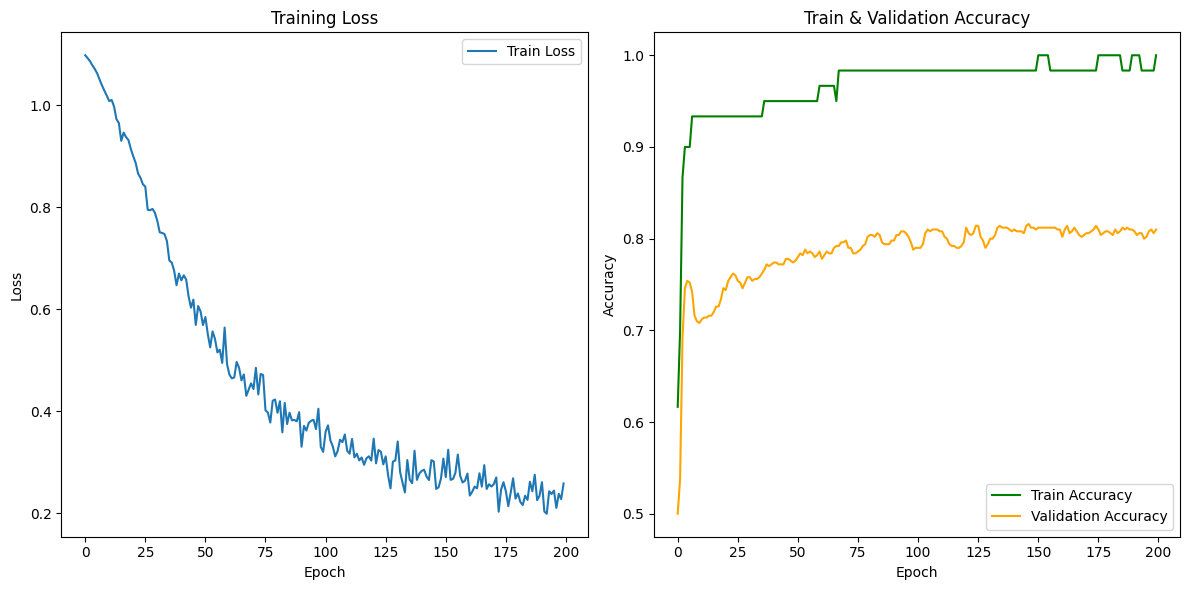

In [ ]:
if not load_model:
    # Final test accuracy
    test_acc = evaluate(data.test_mask)
    print(f'Test Accuracy: {test_acc:.4f}')

    # Plotting the training loss, train accuracy, and validation accuracy
    epochs = range(200)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color='green')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train & Validation Accuracy")
    plt.legend()

    plt.tight_layout()

    plt.savefig('/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3.png')
    plt.show()


In [ ]:
node_explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
node_index = 10
node_explanation = node_explainer(x=data.x, edge_index=data.edge_index, index=node_index)
print(f'Generated explanations in {node_explanation.available_explanations}')

path = '/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_node_feature_importance.png'
node_explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = '/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_node_subgraph.pdf'
node_explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to '/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_node_feature_importance.png'
Subgraph visualization plot has been saved to '/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_node_subgraph.pdf'


In [ ]:
with open('/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_node_explanation.pkl', "wb") as f:
    pickle.dump(node_explanation, f, pickle.HIGHEST_PROTOCOL)
with open('/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_node_explainer.pkl', "wb") as f:
    pickle.dump(node_explainer, f, pickle.HIGHEST_PROTOCOL)

In [ ]:

random_index = random.randint(0, 19717 - 1)
print(f"Randomly selected edge index: {random_index}")

# Create an explainer for edges
edge_explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='edge',
        return_type='log_probs',
    ),
)

# Specify the edge index to explain
edge_index_to_explain = random_index
edge_explanation = edge_explainer(x=data.x, edge_index=data.edge_index, index=edge_index_to_explain)

print(f'Generated explanations in {edge_explanation.available_explanations}')

# Visualize edge subgraph
edge_subgraph_path = '/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_edge_subgraph.pdf'
edge_explanation.visualize_graph(edge_subgraph_path)
print(f"Edge subgraph visualization plot has been saved to '{edge_subgraph_path}'")


Randomly selected edge index: 12913
Generated explanations in ['edge_mask']
Edge subgraph visualization plot has been saved to '/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_edge_subgraph.pdf'


In [ ]:

# Get the important subgraph where zero attribution nodes/edges are masked out
important_subgraph = edge_explanation.get_explanation_subgraph()

print(important_subgraph)

# Visualize the important subgraph
important_subgraph.visualize_graph(path="/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_important_subgraph.png")


Explanation(edge_mask=[114], prediction=[19717, 3], target=[19717], index=[1], x=[19717, 500], edge_index=[2, 114])


In [ ]:
# Get the complement subgraph where any attribution nodes/edges are masked out
complement_subgraph = edge_explanation.get_complement_subgraph()

print(complement_subgraph)

# Visualize the complement subgraph
complement_subgraph.visualize_graph(path="/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_complement_subgraph.png", backend="networkx")


Explanation(edge_mask=[88534], prediction=[19717, 3], target=[19717], index=[1], x=[19717, 500], edge_index=[2, 88534])


Explanation(node_mask=[19717, 500], edge_mask=[88648], prediction=[19717, 3], target=[19717], index=[1], x=[19717, 500], edge_index=[2, 88648])


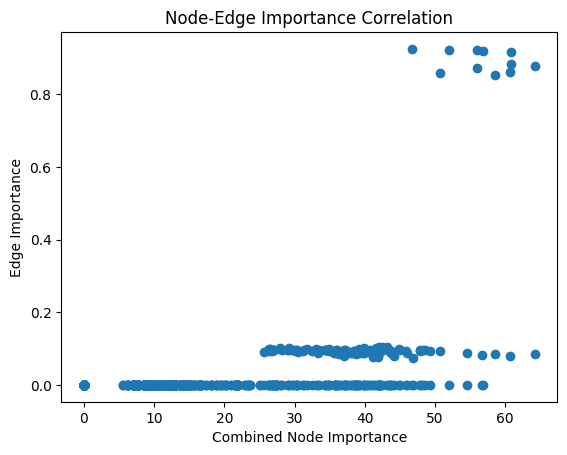

In [ ]:
node_mask = node_explanation.node_mask
edge_mask = node_explanation.edge_mask

# To get node importance (summing across all features for simplicity)
node_importance = node_mask.sum(dim=1)  # [num_nodes]

# Now we can correlate node importance with edge importance
# For this, we will assume edge importance is correlated with the two nodes it connects
# We can aggregate the importance of both nodes connected by an edge
edge_index = node_explanation.edge_index

# Get the importance for both nodes connected by each edge
edge_node_importance = node_importance[edge_index]

# Sum the importance of the two nodes for each edge
combined_node_importance = edge_node_importance.sum(dim=0

# Correlate node importance and edge importance
plt.scatter(combined_node_importance.cpu().numpy(), edge_mask.cpu().numpy())
plt.xlabel('Combined Node Importance')
plt.ylabel('Edge Importance')
plt.title('Node-Edge Importance Correlation')
plt.show()


In [ ]:
import pandas as pd

# Node importance scores
node_importance = node_explanation.node_mask.sum(dim=1).cpu().numpy()  # Sum across features

# Rank nodes by importance
node_ranking = pd.DataFrame({'Node': range(len(node_importance)), 'Importance': node_importance})
node_ranking = node_ranking.sort_values(by='Importance', ascending=False)

print(node_ranking.head(10))  # Top 10 most important nodes


        Node  Importance
5579    5579   32.863403
10        10   31.332649
14471  14471   29.525936
6631    6631   29.377928
13748  13748   27.292459
12126  12126   27.225122
3224    3224   24.711798
15976  15976   21.992884
3287    3287   19.401669
15987  15987   17.392332


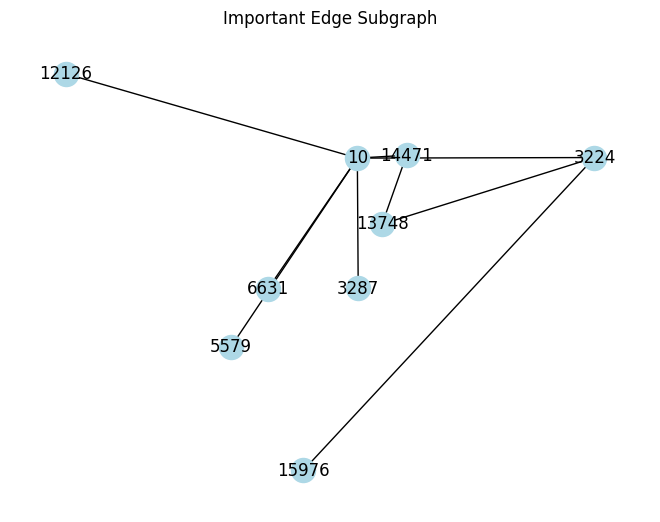

In [ ]:
import torch

# Threshold edge importance
threshold = 0.6
important_edges = node_explanation.edge_mask > threshold

# Create a subgraph of important edges
important_edge_index = node_explanation.edge_index[:, important_edges]

# Visualize the subgraph with important edges
G_sub = nx.Graph()
G_sub.add_edges_from(important_edge_index.T.cpu().numpy())

nx.draw(G_sub, pos, with_labels=True, node_color='lightblue')
plt.title('Important Edge Subgraph')
path="/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_important_edges_subgraph.png"
plt.savefig(path)
plt.show()

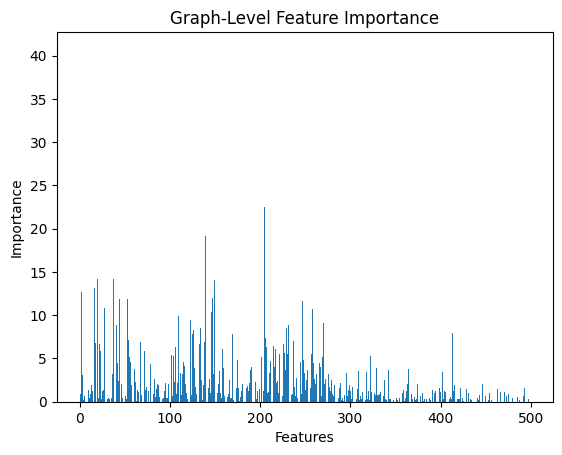

In [ ]:
feature_importance = node_explanation.node_mask.sum(dim=0).numpy()  # Sum across nodes

# Create a bar plot for feature importance
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Graph-Level Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
path="/content/gdrive/My Drive/Machine Learning Assignments/GNN/gnn_explanation_3_graph_level_feature_importance.png"
plt.savefig(path)
plt.show()

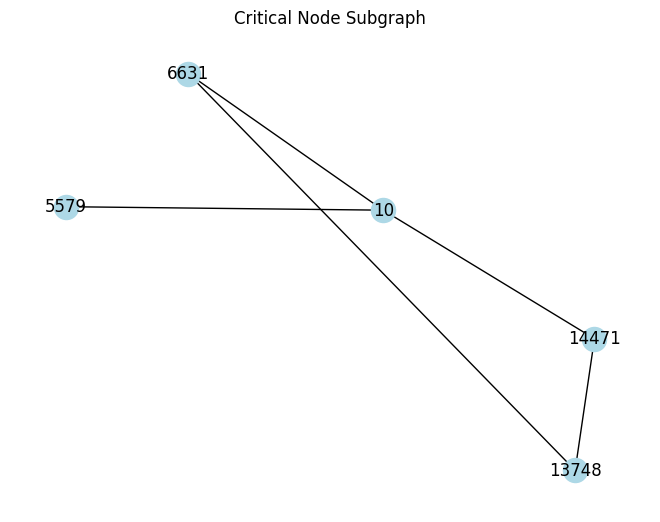

In [ ]:
import torch

# Get top-k important nodes
top_k = 5
node_importance = node_explanation.node_mask.sum(dim=1).cpu().numpy()
top_k_nodes = torch.topk(torch.tensor(node_importance), k=top_k).indices

node_idx_0 = node_explanation.edge_index[0]
node_idx_1 = node_explanation.edge_index[1]

# Check if both nodes of the edge are in the top-k important nodes
top_k_edges = torch.isin(node_idx_0, top_k_nodes) & torch.isin(node_idx_1, top_k_nodes)

# Extract subgraph for top-k nodes
subgraph_edge_index = node_explanation.edge_index[:, top_k_edges]
G_sub = nx.Graph()
G_sub.add_edges_from(subgraph_edge_index.T.cpu().numpy())

# Visualize the critical subgraph
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue')
plt.title('Critical Node Subgraph')
plt.show()
